In [1]:
%load_ext autoreload
%autoreload 2

import json
from itertools import chain

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import roc_auc_score

sns.set()

from biobank_olink.constants import PROJECT_ROOT

In [7]:
results = [json.load(p.open()) for p in (PROJECT_ROOT / "results").iterdir()
           if p.name.startswith("pred_diagnosis")]
results = pd.DataFrame(chain.from_iterable(results))

results.loc[results["ext"].isna(), "ext"] = False

panels = results.panel.unique()

agg_values = {f"mean_{v}": (v, "mean") for v in
              ["auc_score", "num_trials", "best_trial_no", "n_estimators"]}
results.groupby(["years", "lifestyle", "ext", "olink"], dropna=False).agg(**agg_values,
                                                                         count=("model", 'size'))

mean_auc_score  mean_num_trials  \
years lifestyle ext   olink                                    
5     False     False False        0.673203            307.0   
      True      False False        0.719963            306.8   
                True  False        0.724961            306.8   
                      True         0.754327            314.4   
10    False     False False        0.668168            307.0   
      True      False False        0.706769            314.8   
                True  False        0.708042            306.8   
                      True         0.740262            307.0   

                             mean_best_trial_no  mean_n_estimators  count  
years lifestyle ext   olink                                                
5     False     False False               159.2             3908.4      5  
      True      False False               252.8             3062.4      5  
                True  False               235.8             3290.0      5  
                      True                196.6             3096.4      5  
10    False     False False               202.4             2847.8      5  
      True      False False               229.0             2741.8      5  
                True  False               171.4             2578.2      5  
                      True                225.2             3867.6      5

In [29]:
results_gb = results.groupby(["years", "lifestyle", "ext", "olink"], as_index=False)
results_aucs = results_gb.agg({
    "auc_score": "mean",
    "x_shape": lambda v: v.values[0][1] if len(v.dropna()) > 0 else np.nan,
    "y_test": lambda v: np.concatenate(v.values),
    "y_proba": lambda v: np.concatenate(v.values),
})
results_aucs["auc_concat"] = results_aucs.apply(
    lambda row: roc_auc_score(row["y_test"], row["y_proba"]), axis=1)
results_aucs["exp_case"] = results_aucs[["lifestyle", "ext", "olink"]].apply(
    lambda row: "+".join(row.index[row].tolist()), axis=1)
results_aucs["exp_case"] = results_aucs["exp_case"].apply(
    lambda v: "age+sex" + ("+" if v else "") + v)
results_aucs = results_aucs.pivot(index=["exp_case", "x_shape"], columns="years",
                                  values=["auc_score", "auc_concat"])
results_aucs.index = [f"{name} ({num_col})" for name, num_col in results_aucs.index.to_flat_index()]
results_aucs

auc_score           auc_concat          
years                                     5         10         5         10
age+sex (2)                         0.673203  0.668168   0.635018  0.653047
age+sex+lifestyle (18)              0.719963  0.706769   0.704103  0.702040
age+sex+lifestyle+ext (35)          0.724961  0.708042   0.674377  0.694251
age+sex+lifestyle+ext+olink (2750)  0.754327  0.740262   0.740586  0.736929

In [31]:
results_gb.agg(auc_std=("auc_score", "std"))

,years,lifestyle,ext,olink,auc_std
0,5,False,False,False,0.033700
1,5,True,False,False,0.028652
2,5,True,True,False,0.031020
3,5,True,True,True,0.027651
4,10,False,False,False,0.012134
5,10,True,False,False,0.020568
6,10,True,True,False,0.022387
7,10,True,True,True,0.016157


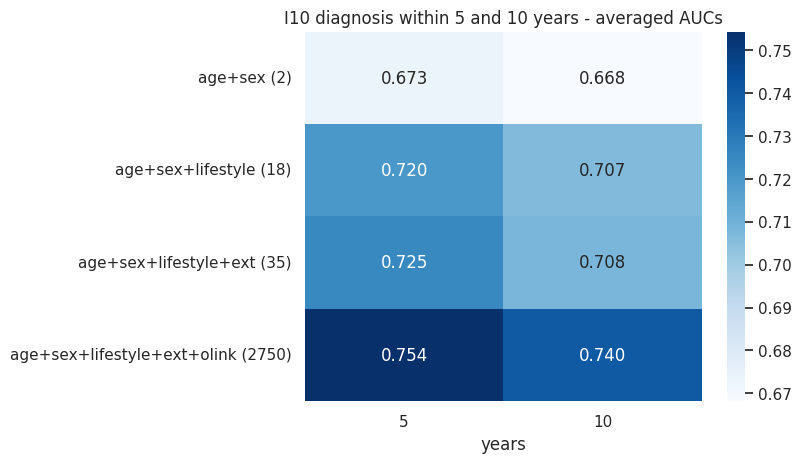

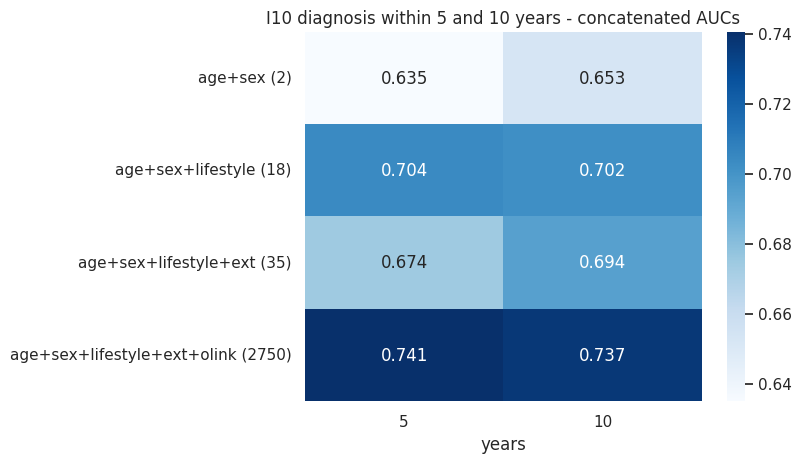

In [25]:
heatmap_kwargs = dict(annot=True, fmt=".3f", cmap="Blues")
# heatmaps
sns.heatmap(data=results_aucs["auc_score"], **heatmap_kwargs)
plt.title("I10 diagnosis within 5 and 10 years - averaged AUCs")
plt.show()

sns.heatmap(data=results_aucs["auc_concat"], **heatmap_kwargs)
plt.title("I10 diagnosis within 5 and 10 years - concatenated AUCs")
plt.show()

In [34]:
trans_results = [json.load(p.open()) for p in (PROJECT_ROOT / "results").iterdir()
               if p.name.startswith("trans")]
trans_results  = pd.DataFrame(chain.from_iterable(trans_results ))
trans_results

,auc_score,timestamp,fold_num,best_trial_no,num_trials,study_name,model,panel,nan_th,corr_th,...,n_layer,n_embd,n_head,dropout,vocab_size,bias,d_ff,in_feats,y_test,y_proba
0,0.766272,10/11/2023 17:42:40,1,74,100,transformer_corr0.9,TRANSFORMER,ALL,0.0,0.9,...,1,16,2,0.469685,6,True,72,2715,"[[True], [False], [False], [False], [False], [...","[0.9024361371994019, 0.5760928392410278, 0.934..."
1,0.767471,10/11/2023 23:17:17,2,50,100,transformer_corr0.9,TRANSFORMER,ALL,0.0,0.9,...,1,8,2,0.499764,10,False,112,2715,"[[True], [False], [False], [False], [False], [...","[0.7436263561248779, 0.6319836974143982, 0.631..."
2,0.736741,11/11/2023 02:49:40,0,104,100,transformer_corr0.9,TRANSFORMER,ALL,0.0,0.9,...,2,8,1,0.499934,30,True,24,2715,"[[False], [True], [True], [False], [True], [Tr...","[0.12879295647144318, 0.9714751243591309, 0.74..."
3,0.773442,11/11/2023 04:18:33,4,84,100,transformer_corr0.9,TRANSFORMER,ALL,0.0,0.9,...,2,48,2,0.385524,6,False,24,2715,"[[True], [True], [False], [True], [True], [Tru...","[0.9525943994522095, 0.09454325586557388, 0.09..."
4,0.712214,12/11/2023 20:21:10,3,94,100,transformer_corr0.9,TRANSFORMER,ALL,0.0,0.9,...,1,128,2,0.023867,61,False,128,2715,"[[True], [True], [True], [True], [True], [True...","[0.9914581179618835, 0.9999562501907349, 0.999..."
